In [29]:
# This notebook addresses class imbalance in the image classification project using:
# - Class weighting
# - Basic data augmentation
# - Optional GPU acceleration on Mac via `MAC_MODE`
# - Visualization of accuracy and loss


In [30]:
import os
import platform
import tensorflow as tf

# Toggle for local Mac GPU support
MAC_MODE = True  # Set to False for Windows/Linux

if MAC_MODE:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    print("Mac mode enabled (Metal acceleration will be used if available).")
else:
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"Using GPU: {physical_devices[0].name}")
    else:
        print("No GPU found. Running on CPU.")


Mac mode enabled (Metal acceleration will be used if available).


In [31]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "data_split"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

image_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
).flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical'
)


Found 4007 images belonging to 3 classes.
Found 1861 images belonging to 3 classes.


In [32]:
from sklearn.utils.class_weight import compute_class_weight

counts = train_gen.classes
weights = compute_class_weight(class_weight="balanced", classes=np.unique(counts), y=counts)
class_weights = dict(zip(np.unique(counts), weights))
print("Computed class weights:", class_weights)


Computed class weights: {0: 6.920552677029361, 1: 3.710185185185185, 2: 0.38670140899440264}


In [33]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam


base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Freeze up to the last 50 layers
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(3, activation="softmax")
])

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [34]:
tf.debugging.set_log_device_placement(True)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    class_weight=class_weights,
    verbose=1
)


/Users/daniel/miniconda3/envs/data_engineering/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 252ms/step - accuracy: 0.3242 - loss: 1.1230 - val_accuracy: 0.0903 - val_loss: 1.4973
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.4409 - loss: 0.9813 - val_accuracy: 0.5572 - val_loss: 0.9496
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.4847 - loss: 1.0188 - val_accuracy: 0.4105 - val_loss: 1.0500
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 226ms/step - accuracy: 0.4859 - loss: 0.9907 - val_accuracy: 0.4981 - val_loss: 1.0491
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.5721 - loss: 0.9248 - val_accuracy: 0.2305 - val_loss: 1.2084
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.5554 - loss: 0.9449 - val_accuracy: 0.7856 - val_loss: 0.5793
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.5407 - loss: 0.9856 - val_accuracy: 0.8495 - val_loss: 0.4954
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.5853 - loss: 0

In [35]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


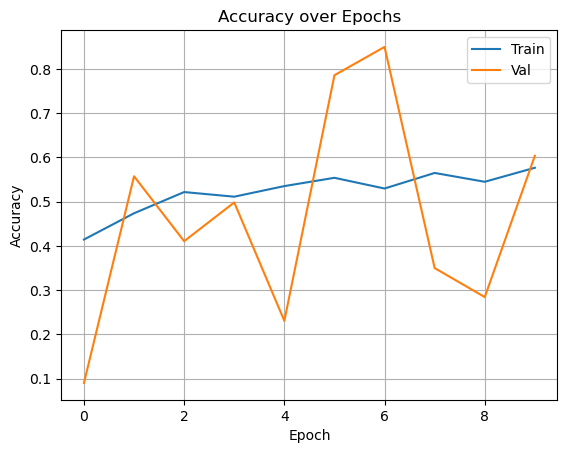

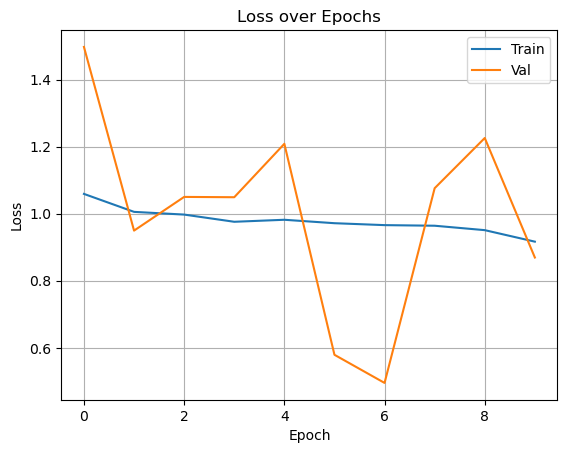

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Val")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Val")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [38]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datetime import datetime


def run_training(stage=1, data_dir="data_split", image_size=(224, 224), batch_size=32):
    """
    Run staged fine-tuning with ResNet50 and visualize results.
    
    Parameters:
    - stage: 1, 2, or 3
    - data_dir: must contain 'train' and 'test' subdirs
    - image_size: tuple (H, W)
    - batch_size: int

    Returns:
    - model: final trained model
    """
    print(f"🔁 Starting {stage}-stage training")

    # Set up paths
    train_dir = os.path.join(data_dir, "train")
    test_dir = os.path.join(data_dir, "test")

    # Image generators
    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    ).flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=True)

    test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=False
    )

    # Class weights
    counts = train_gen.classes
    weights = compute_class_weight(class_weight="balanced", classes=np.unique(counts), y=counts)
    class_weights = dict(zip(np.unique(counts), weights))

    # Model
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(*image_size, 3))
    model = Sequential([base_model, GlobalAveragePooling2D(), Dense(3, activation="softmax")])

    def plot_history(history, label):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'bo-', label='Train')
        plt.plot(epochs, val_acc, 'ro-', label='Val')
        plt.title(f'{label} - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'bo-', label='Train')
        plt.plot(epochs, val_loss, 'ro-', label='Val')
        plt.title(f'{label} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def get_tensorboard_callback(stage_name):
        log_dir = f"logs/{stage_name}_" + datetime.now().strftime("%Y%m%d-%H%M%S")
        return TensorBoard(log_dir=log_dir, histogram_freq=1)

    history_all = []

    # STAGE 1: Train top layers only
    if stage >= 1:
        print("🔹 Stage 1: training top layers (frozen base)")
        base_model.trainable = False
        model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(train_gen, validation_data=test_gen, epochs=3, class_weight=class_weights,
                         callbacks=[get_tensorboard_callback("stage1")])
        history_all.append(hist)
        plot_history(hist, "Stage 1")

    # STAGE 2: Fine-tune last 30 layers
    if stage >= 2:
        print("🔹 Stage 2: fine-tuning last 30 layers")
        base_model.trainable = True
        for layer in base_model.layers[:-30]:
            layer.trainable = False
        model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(train_gen, validation_data=test_gen, epochs=5, class_weight=class_weights,
                         callbacks=[get_tensorboard_callback("stage2")])
        history_all.append(hist)
        plot_history(hist, "Stage 2")

    # STAGE 3: Fine-tune full model
    if stage >= 3:
        print("🔹 Stage 3: full model fine-tuning")
        for layer in base_model.layers:
            layer.trainable = True
        model.compile(optimizer=Adam(1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(train_gen, validation_data=test_gen, epochs=5, class_weight=class_weights,
                         callbacks=[get_tensorboard_callback("stage3")])
        history_all.append(hist)
        plot_history(hist, "Stage 3")

    # 📉 Confusion matrix on test set
    print("📊 Final Confusion Matrix:")
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    labels = list(test_gen.class_indices.keys())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues')
    plt.xticks(rotation=20)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    return model


🔁 Starting 3-stage training
Found 4007 images belonging to 3 classes.
Found 1861 images belonging to 3 classes.
🔹 Stage 1: training top layers (frozen base)


/Users/daniel/miniconda3/envs/data_engineering/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 223ms/step - accuracy: 0.3137 - loss: 1.1914 - val_accuracy: 0.0677 - val_loss: 1.3399
Epoch 2/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - accuracy: 0.2901 - loss: 1.1167 - val_accuracy: 0.3240 - val_loss: 1.0498
Epoch 3/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - accuracy: 0.3369 - loss: 1.0806 - val_accuracy: 0.0978 - val_loss: 1.1371


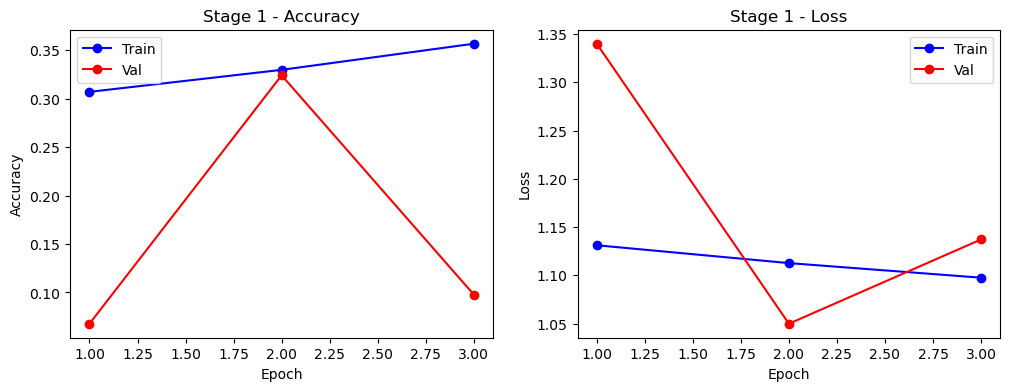

🔹 Stage 2: fine-tuning last 30 layers
Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 243ms/step - accuracy: 0.7513 - loss: 5.0960 - val_accuracy: 0.8608 - val_loss: 0.5229
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.5125 - loss: 1.0386 - val_accuracy: 0.5255 - val_loss: 0.9006
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.4985 - loss: 1.0146 - val_accuracy: 0.5879 - val_loss: 0.9251
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.5330 - loss: 0.9686 - val_accuracy: 0.6706 - val_loss: 0.7727
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.5621 - loss: 0.9672 - val_accuracy: 0.5626 - val_loss: 0.8788


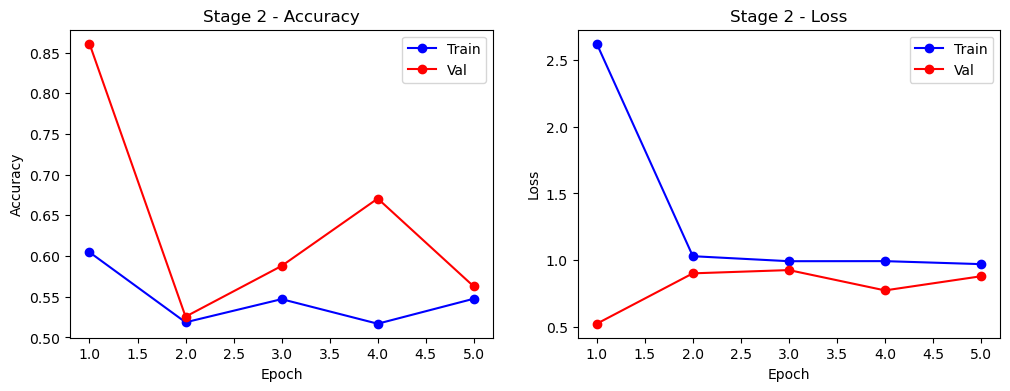

🔹 Stage 3: full model fine-tuning
Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 112s 597ms/step - accuracy: 0.8654 - loss: 15.7684 - val_accuracy: 0.8608 - val_loss: 4.4632
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 67s 530ms/step - accuracy: 0.8638 - loss: 13.6475 - val_accuracy: 0.8608 - val_loss: 5.9579
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 66s 522ms/step - accuracy: 0.8577 - loss: 12.6250 - val_accuracy: 0.8608 - val_loss: 5.3425
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 66s 520ms/step - accuracy: 0.8566 - loss: 11.0635 - val_accuracy: 0.8608 - val_loss: 4.0545
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 518ms/step - accuracy: 0.8615 - loss: 8.9813 - val_accuracy: 0.8608 - val_loss: 3.4340


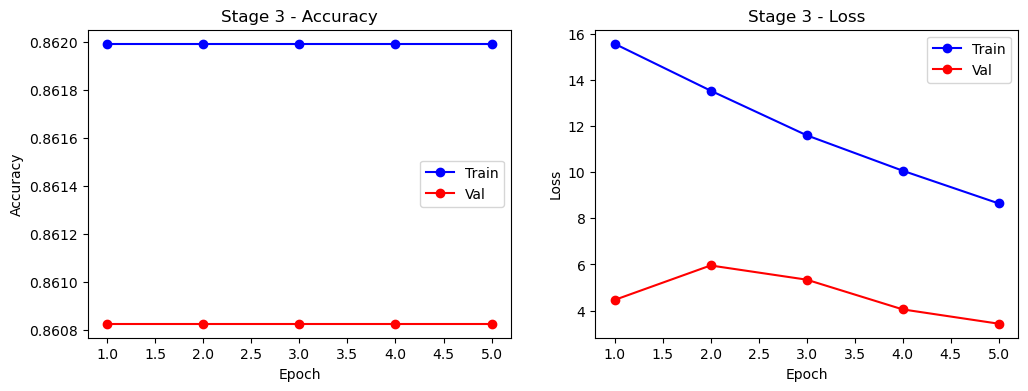

📊 Final Confusion Matrix:
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step


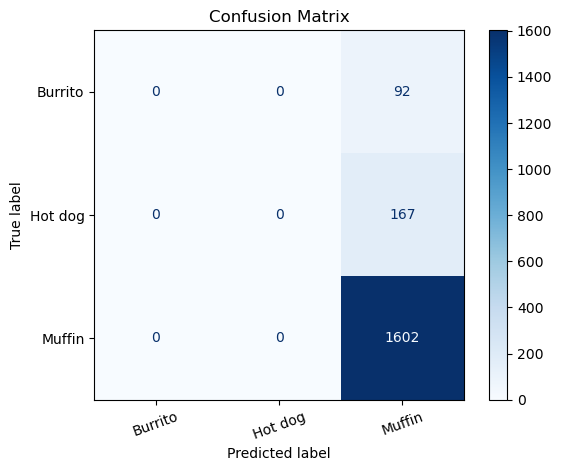

In [39]:
model = run_training(stage=3)
